## University Ranking Predictions

In [99]:
%matplotlib inline
import pandas as pd
import numpy as np
shanghai_data_full = pd.read_csv("data/shanghaiData.csv")
shanghai_data_full = shanghai_data_full[shanghai_data_full.total_score.notnull()]
shanghai_data_full.head()

,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year
0,1,Harvard University,1,100.0,100.0,100.0,100.0,100.0,100.0,72.4,2005
1,2,University of Cambridge,1,73.6,99.8,93.4,53.3,56.6,70.9,66.9,2005
2,3,Stanford University,2,73.4,41.1,72.2,88.5,70.9,72.3,65.0,2005
3,4,"University of California, Berkeley",3,72.8,71.8,76.0,69.4,73.9,72.2,52.7,2005
4,5,Massachusetts Institute of Technology (MIT),4,70.1,74.0,80.6,66.7,65.8,64.3,53.0,2005


## Split to Training and Test

In [117]:
rows = np.random.choice(shanghai_data_full.index.values, 500)
shanghai_data_test = shanghai_data_full.ix[rows].sort_index()
shanghai_data = shanghai_data_full.drop(rows)

features_with_year = ['total_score', 'university_name', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp', 'year']
prediction_data = shanghai_data.loc[:,features_with_year]
prediction_data_test = shanghai_data_test.loc[:,features_with_year]

## Scaling Features

In [118]:
from sklearn.preprocessing import StandardScaler

to_predict = ['total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp', 'year']
scaler = StandardScaler()
scaler.fit(prediction_data.loc[:,to_predict])
prediction_data.loc[:,to_predict] = scaler.transform(prediction_data.loc[:,to_predict])
prediction_data_test.loc[:,to_predict] = scaler.transform(prediction_data_test.loc[:,to_predict])
prediction_data.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year
0,4.517067,Harvard University,-0.880886,3.963923,3.289278,3.835987,4.304989,3.767272,3.189989,-1.594844
1,2.639709,University of Cambridge,-0.880886,3.953290,2.992949,1.058087,1.530025,1.382855,2.760237,-1.594844
2,2.625487,Stanford University,-0.818274,0.832515,2.041104,3.151922,2.444357,1.497569,2.611778,-1.594844
3,2.582820,"University of California, Berkeley",-0.755663,2.464675,2.211718,2.015778,2.636174,1.489375,1.650696,-1.594844
6,1.836143,Columbia University,-0.567828,2.868728,1.520284,1.224642,1.376571,1.268140,1.080299,-1.594844


## Using Multiple Past Years

In [119]:
years_back = [1, 2, 3, 4]
for index, row in prediction_data.iterrows():
    is_complete = True
    past_rows = {}
    for year in years_back:
        past_row = prediction_data[(prediction_data.university_name == row.university_name) & (prediction_data.year == row.year-year)]
        past_rows[year] = past_row
        if len(past_row.values) == 0:
            is_complete = False
    
    if (is_complete):
        for year in years_back:
            past_row = past_rows[year]
            for feature in to_predict:
                prediction_data.loc[index, feature + '_back_' + str(year)] = past_row[feature].values[0]

complete_filter = prediction_data.apply(lambda row : np.isnan(row['total_score_back_' + str(len(years_back))]),axis=1) 
prediction_data_clean = prediction_data[~complete_filter]
prediction_data_clean.head()

KeyError: ('total_score_back_4', 'occurred at index 0')

## Dont Modify `prediction_data_clean` From Here 

In [82]:
features = []
for feature in to_predict:
    for year in years_back:
        features.append(feature + '_back_' + str(year))

In [95]:
X = prediction_data_clean.loc[:,features]

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
clf_map = {}
# Just going to use Linear for now to save time
# Don't know how to split training set properly here to save test set
# Can we score ourself with a few iterations down the line?
for feature in to_predict:
    clf = LinearRegression()
    y = np.ravel(prediction_data_clean.loc[:,[feature]])
    clf.fit(X, y)
    clf_map[feature] = clf
    cv_scores = cross_val_score(clf, X, y, cv=3)
    print (cv_scores)

[ 0.99693378  0.99682149  0.99443684]
[ 0.99448781  0.99649113  0.99565457]
[ 0.97194622  0.9591567   0.98144778]
[ 0.99647735  0.98815466  0.99535881]
[ 0.99268386  0.99551098  0.95411649]
[ 0.98734241  0.98479114  0.96385923]
[ 0.99268386  0.99551098  0.95411649]
[ 0.9830766   0.98700564  0.9754256 ]
[ 0.90010072  0.97787447  0.97787904]
[ 1.  1.  1.]


## Make Prediction Code Reuseable

In [87]:
import seaborn as sb
import matplotlib.pyplot as plt

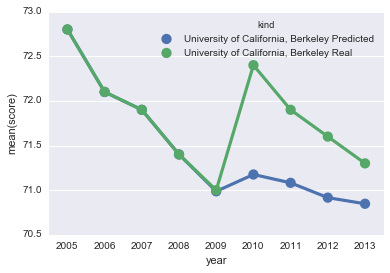

In [88]:
def get_school_graph_data(school_name_to_predict):
    university_data = prediction_data_next[(prediction_data_next.university_name == school_name_to_predict) & (prediction_data_next.year == (2005 + len(years_back)))]
    X = university_data.loc[:,features]
    start_scores = X['total_score_back_' + str(len(years_back))].values
    for i in range(1,len(years_back)):
        start_scores = np.append(start_scores, X['total_score_back_' + str(len(years_back)-i)].values)

    real_scores = prediction_data_next[prediction_data_next.university_name == school_name_to_predict]['total_score'].values
    real_scores = np.append(start_scores, real_scores)
    
    predicted_scores = start_scores.copy()
    X_continue = X.copy()
    for i in range(len(real_scores) - len(years_back)):
        X_original = X_continue.copy()
        for feature in to_predict:
            X_continue[feature + '_back_1'] = clf_map[feature].predict(X_original)
            for i in range(1,len(years_back)):
                X_continue[feature + '_back_' + str(i + 1)] = X_original[feature + '_back_' + str(i)]
        predicted_scores = np.append(predicted_scores, X_continue['total_score_back_1'].values)

    end_year = 2005 + len(real_scores)
    years = np.array(range(2005, end_year))
    predicted = pd.DataFrame({ 'score' : predicted_scores, 'year' : years })
    real = pd.DataFrame({ 'score' : real_scores, 'year' : years })
    predicted['kind'] = school_name_to_predict + ' Predicted'
    real['kind'] = school_name_to_predict + ' Real'
    graph_data = predicted.append(real)
    return graph_data

prediction_data_next = prediction_data_clean.copy()
school_name_to_predict = ['University of California, Berkeley']
graph_data = get_school_graph_data(school_name_to_predict[0])
graph = sb.pointplot(x='year', y='score', hue='kind', data=graph_data)

In [89]:
def plot_scores_by_names(universities_to_plot):
    graph_data = pd.DataFrame()
    num_universitites = len(universities_to_plot)
    linestyles = ["-", "--"]*num_universitites
    markers= ["o", "x"]*num_universitites
    palette = np.repeat(sb.color_palette("Set1", n_colors=num_universitites, desat=.5), 2, axis=0)

    for name in universities_to_plot:
        graph_data = graph_data.append(get_school_graph_data(name))
    fig, (ax) = plt.subplots(1,1, figsize=(20,10))
    sb.pointplot(x='year', y='score', hue='kind', linestyles=linestyles, markers=markers, palette=palette, data=graph_data, ax=ax)

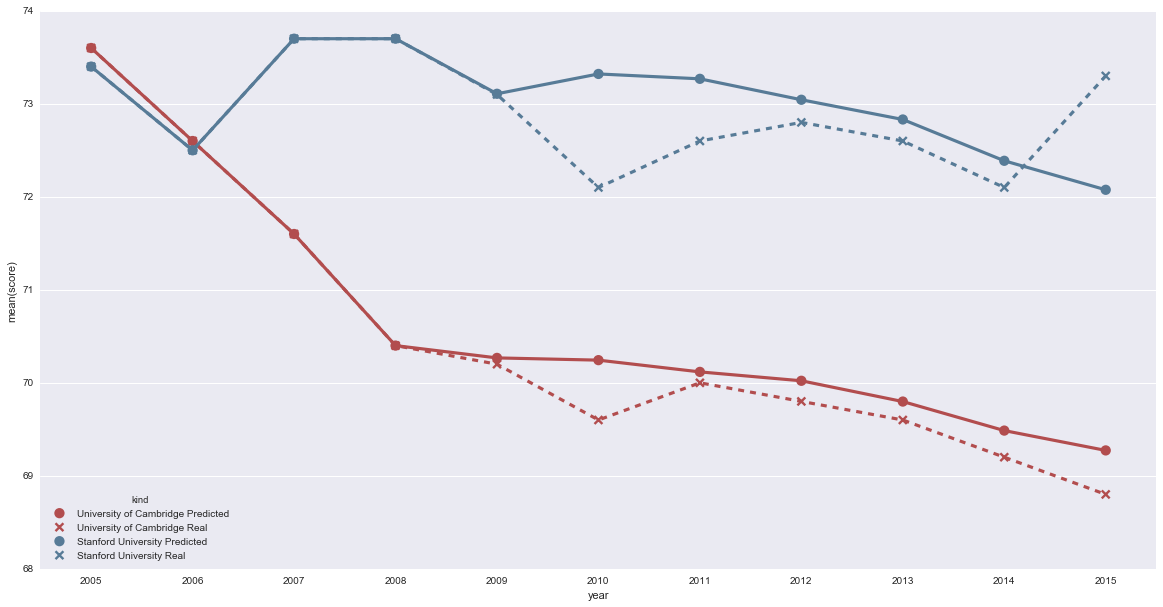

In [90]:
plot_scores_by_names(shanghai_data[1:3]['university_name'].values)

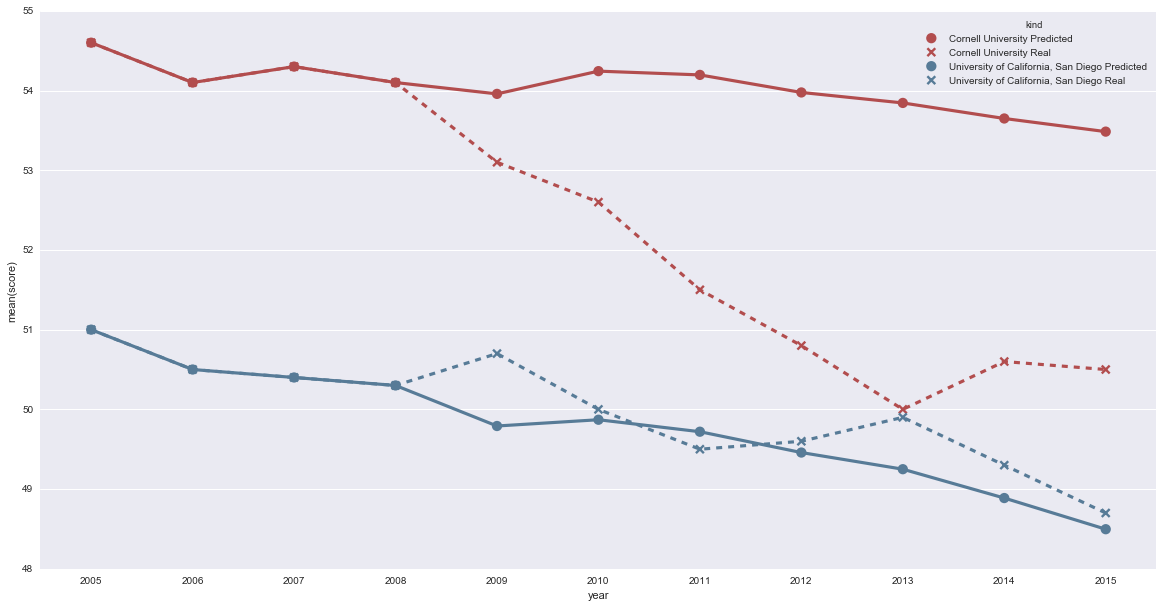

In [91]:
plot_scores_by_names(shanghai_data[11:13]['university_name'].values)

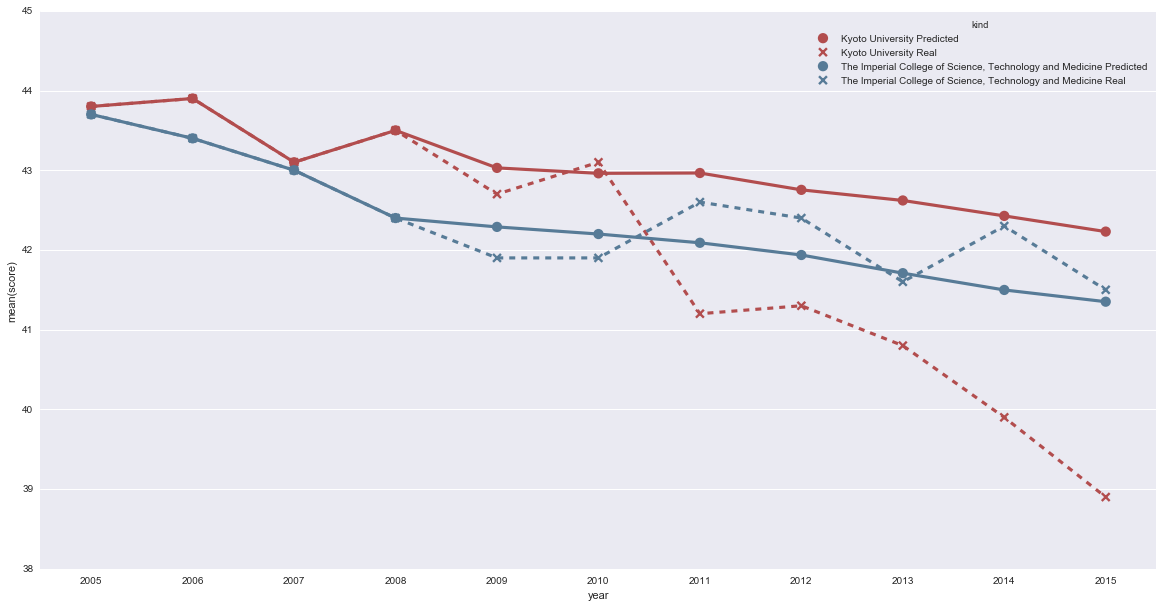

In [92]:
plot_scores_by_names(shanghai_data[21:23]['university_name'].values)

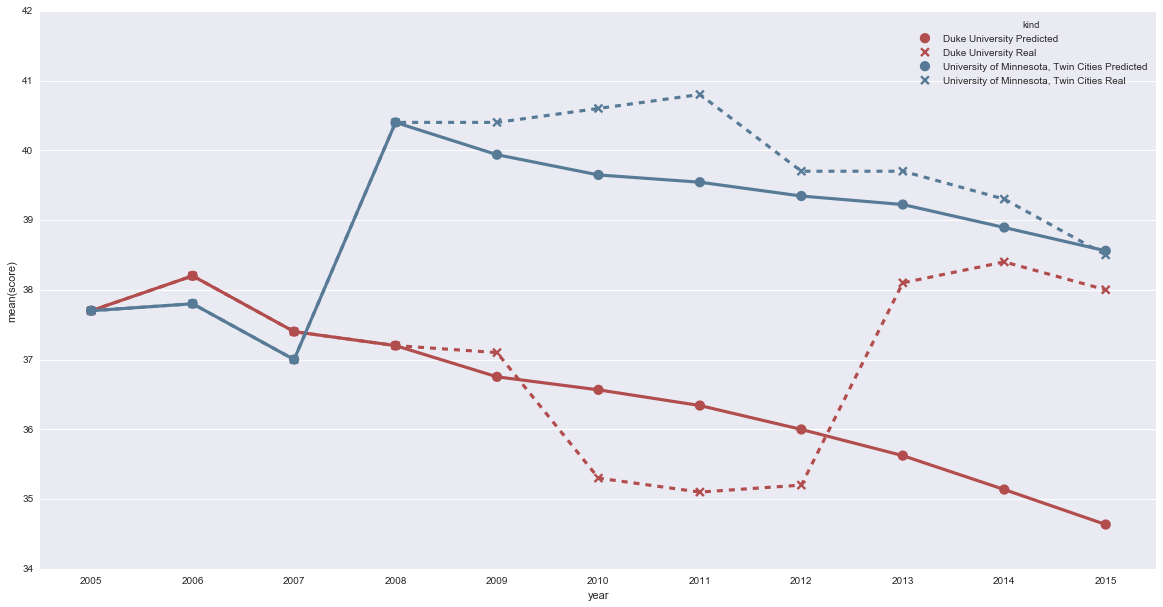

In [93]:
plot_scores_by_names(shanghai_data[31:33]['university_name'].values)

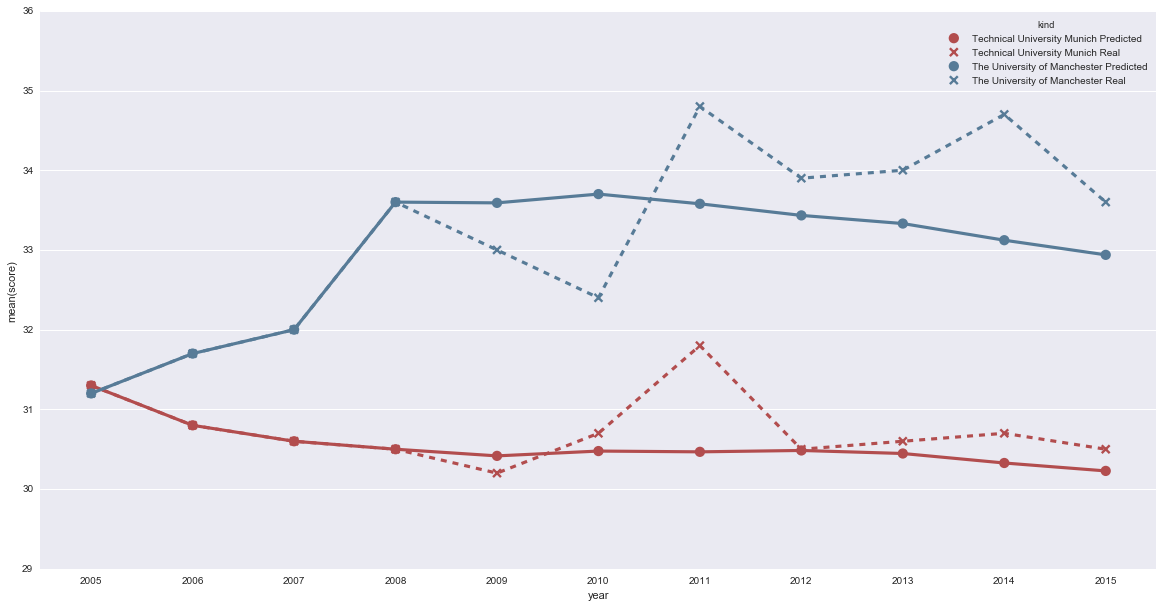

In [94]:
plot_scores_by_names(shanghai_data[51:53]['university_name'].values)